# Machine Learning Project - Deshan Fonseka

# Introduction
The goal is to build a fraud detection model using different types of machine learning algorithms. The first algorithm is a supervised learning algorithm, that is Light Gradient Boosting which is then compared to an unsupervised learning algorithm, which is autoencoders. The results of the two models are then compared. Finally, a semi-supervised model is built using as input of the supervised model the representations learned from the autoencoders.

# Overview of the dataset
The dataset contains anonymized credit card transactions made by European cardholders in two days, in September 2013. The dataset presents 284807 transactions which are labeled as fraudelent or genuine, with only 492 (0.172%) of them being frauds, meaning that the dataset is highly imbalanced.   

There are 28 numerical features; however, these features are not the original ones but the output of principal component analysis.

In addition to the 29 principal components, there are three other variables such as the time of the transaction, the amount of the transaction and the true class of the transaction (1 if fraud, 0 if genuine).

In [262]:
# Link to the dataset: https://www.kaggle.com/mlg-ulb/creditcardfraud

#### Import the necessary libraries

In [81]:
# Main libraries
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

%matplotlib inline

# Data preprocessing
from sklearn import preprocessing as pp 
from scipy.stats import pearsonr 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss 
from sklearn.metrics import precision_recall_curve, average_precision_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report 

# Algorithms
import lightgbm as lgb

### Data Preparation

In [82]:
# Read the data
data = pd.read_csv('creditcard.csv')

In [83]:
# Explore the dataset
data.shape

(284807, 31)

In [84]:
# Show first five ows of the dataset
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [85]:
# Generate summary statistics column by column
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [86]:
# Show all the features
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [87]:
# Show the number of fraudulent transactions in the dataset
print("Number of fraudulent transactions:", data['Class'].sum())


Number of fraudulent transactions: 492


In [88]:
CountNaNs = np.isnan(data).sum()
CountNaNs

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [89]:
# Identify distinct values by feature
CountDistinctValues = data.apply(lambda x: len(x.unique()))
CountDistinctValues

Time      124592
V1        275663
V2        275663
V3        275663
V4        275663
V5        275663
V6        275663
V7        275663
V8        275663
V9        275663
V10       275663
V11       275663
V12       275663
V13       275663
V14       275663
V15       275663
V16       275663
V17       275663
V18       275663
V19       275663
V20       275663
V21       275663
V22       275663
V23       275663
V24       275663
V25       275663
V26       275663
V27       275663
V28       275663
Amount     32767
Class          2
dtype: int64

In [90]:
# Generate feature matrix and labels array
dataX = data.copy().drop(['Class'],axis=1)
dataY = data['Class'].copy()

In [91]:
# Feature scaling
featuresToScale = dataX.drop(['Time'],axis=1).columns
featuresToScale

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [92]:
# Standardize the features to have a mean of zero and a standard deviation of one
standardizeX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = standardizeX.fit_transform(dataX[featuresToScale])
scaliedFeatures = pd.DataFrame(data=[standardizeX.mean_,standardizeX.scale_],index=['Mean','StDev'],columns=featuresToScale)
scaliedFeatures

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Mean,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,2.239751e-15,...,6.406703e-16,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619
StDev,1.958692e+00,1.651306e+00,1.516252e+00,1.415866e+00,1.380244e+00,1.332269e+00,1.237091e+00,1.194351e+00,1.098630e+00,1.088848e+00,...,7.709237e-01,7.345227e-01,7.257003e-01,6.244592e-01,6.056460e-01,5.212772e-01,4.822262e-01,4.036318e-01,3.300827e-01,250.119670


In [93]:
# Generate summary statistics of the scaled features column by column
dataX.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05
mean,94813.859575,-8.157366e-16,3.154853e-17,-4.409878e-15,-6.734811e-16,-2.874435e-16,4.168992e-16,-8.767997e-16,-2.423604e-16,3.078727e-16,...,2.754870e-16,1.685077e-17,1.478472e-15,-6.797197e-16,1.234659e-16,-7.659279e-16,3.247603e-16,-2.953495e-18,5.401572e-17,3.202236e-16
std,47488.145955,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,0.000000,-2.879855e+01,-4.403529e+01,-3.187173e+01,-4.013919e+00,-8.240810e+01,-1.963606e+01,-3.520940e+01,-6.130252e+01,-1.222802e+01,...,-7.069146e+01,-4.741907e+01,-1.506565e+01,-7.175446e+01,-4.683638e+00,-1.975033e+01,-5.401098e+00,-5.590660e+01,-4.674612e+01,-3.532294e-01
25%,54201.500000,-4.698918e-01,-3.624707e-01,-5.872142e-01,-5.993788e-01,-5.010686e-01,-5.766822e-01,-4.478860e-01,-1.746805e-01,-5.853631e-01,...,-2.746334e-01,-3.109433e-01,-7.473476e-01,-2.591784e-01,-5.854676e-01,-6.084001e-01,-6.780717e-01,-1.755053e-01,-1.604440e-01,-3.308401e-01
50%,84692.000000,9.245351e-03,3.965683e-02,1.186124e-01,-1.401724e-02,-3.936682e-02,-2.058046e-01,3.241723e-02,1.871982e-02,-4.681169e-02,...,-8.104705e-02,-4.009429e-02,9.345377e-03,-1.792420e-02,6.765678e-02,3.183240e-02,-1.081217e-01,3.325174e-03,3.406368e-02,-2.652715e-01
75%,139320.500000,6.716939e-01,4.867202e-01,6.774569e-01,5.250082e-01,4.433465e-01,2.991625e-01,4.611107e-01,2.740785e-01,5.435305e-01,...,1.725733e-01,2.537392e-01,7.283360e-01,2.364319e-01,7.257153e-01,6.728006e-01,4.996663e-01,2.255648e-01,2.371526e-01,-4.471707e-02
max,172792.000000,1.253351e+00,1.335775e+01,6.187993e+00,1.191874e+01,2.521413e+01,5.502015e+01,9.747824e+01,1.675153e+01,1.419494e+01,...,5.113464e+01,3.703471e+01,1.447304e+01,3.607668e+01,7.569684e+00,1.442532e+01,7.293975e+00,7.831940e+01,1.025434e+02,1.023622e+02


In [94]:
# Check correlation of features
correlationMatrix = pd.DataFrame(data=[],index=dataX.columns,columns=dataX.columns)
for i in dataX.columns:
    for j in dataX.columns:
        correlationMatrix.loc[i,j] = np.round(pearsonr(dataX.loc[:,i],dataX.loc[:,j])[0],2)

Text(0, 0.5, 'Frequency Percentage')

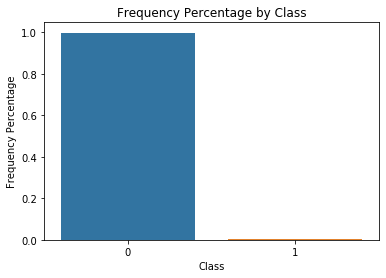

In [95]:
# Visualize the data to see how imbalanced the dataset is
count_classes = pd.value_counts(data['Class'],sort=True).sort_index()
ax = sns.barplot(x=count_classes.index, y=tuple(count_classes/len(data)))
ax.set_title('Frequency Percentage by Class')
ax.set_xlabel('Class')
ax.set_ylabel('Frequency Percentage')

### Model Preparation
This stage consists of preparing the data for the model splitting the data into a training and test set, selecting a cost funcion and preparing for k-fold cross-validation.

In [96]:
# Split into training ad test sets
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.33, 
                                                    random_state=2023, stratify=dataY)  # stratifify parameter is used to preserve the percentage of fraud

In [97]:
# Transactions in the training set
len(X_train)

190820

In [98]:
# Transactions in the test test
len(X_test)


93987

In [99]:
# Percentage of fraud in the training set
y_train.sum()/len(y_train)

0.0017293784718582959

In [100]:
# Percentage of fraud in the test set
y_test.sum()/len(y_test)

0.0017236426314277506

Now the training set have 190280 instances (67% of the original dataset) and a test set with 93987 (the remaining 33% of the original dataset). The stratify parameter is used to preserve the percentage of fraud (~0.17%) for both training and test set.

### Selection of the cost function
Since this is a supervised classification problem with two classes, binary classification log loss will be used to calculate the cross-entropy between the true labels and the model's predictions. The model will generate the fraud probability for each credit card transaction. The closer the fraud probabilities are to the true labels, the lower the value of the log loss function. This is what the machine learning algorithm will try to minimize.

### Create k-Fold Cross-Validation Sets
To help the machine learning algorithm estimate what its perfomance will be on the never before seen examples, the training set will be further split into five sets. By splitting the training set into fifths, it is possible to train on fourth fifths of the original training set and evaluate the newly training model by making predictions on the fith slice of the original training set.


In [101]:
# Create k-fold cross-validation sets
k_fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2023)

### Evaluation Metrics

#### Precision-Recall Curve
Although the log loss is a great way to estimate the performance of the machine learning model, there is a more intuitive way to understand the results. In fact, for this imbalanced credit card dataset, a better way to evaluate the results is to use precision and recall. Precision is the number of true positives over the number of total predictions whereas recall is the number of true positives over the number of total actual positives in the dataset.

If the solution will have high precision but low recall, there would be a very small number of fraudolent transactions found but most will be truly fraudulent. However, if the solution had low precision but high recall, it would flag many of the transactions as fraudolent, catching a lot of the fraud, but most od the flagged transactions would not be fraudulent.

An optimal solution needs to have high precision and high recall, rejecting only those transactions that are truly fraudulent (high precision) and catching most of the fraudulent cases in the dataset (high recall).

The precision recall is a graph of the trade-off between precision and recall evaluated calculating the average precision, which is the weighted mean of the precision achieved at each treshold. The higher the average precision, the better the solution.

#### Receiver Operating Characteristic
Another good evaluation metric is the area under the receiver operating characteristic (auROC). The ROC curve plots the true positive rate on the Y axis and the false positive rate on the X axis. The closer the curve is to the top-left corner of the plot, the better the solution, with a value of (0.0, 1.0) as the absolute optimal point, signifying a 0% false positive rate and a 100% true positive rate.

The area under this curve is computed to evaluate the solution. The larger the auROC, the better the solution.

# Supervised Model : Light Gradient Boosting Machine
#### Set the hyperparameters
The maximum depth of each tree is seto to 4 and the learning rate is 0.1. All the samples and all the features will be used for each tree.

In [102]:
# Set hyperparameters fo LightGBM
params_lightGB = {
    'task': 'train',
    'application':'binary',
    'num_class':1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2023,
    'verbose': 0,
    'num_threads':16
}

In [103]:
# Train the model using k-fold cross validation (k=5)
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[], index=y_train.index,columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000, valid_sets=lgb_eval, early_stopping_rounds=200)
    
    # Calculate cross entropy loss in training
    loglossTraining = log_loss(y_train_fold, gbm.predict(X_train_fold, num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLightGBMGradientBoosting = log_loss(y_train, predictionsBasedOnKFolds.loc[:,'prediction'])
print('LightGBM Gradient Boosting Log Loss: ', loglossLightGBMGradientBoosting)

[1]	valid_0's binary_logloss: 0.00603648
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.00597282
[3]	valid_0's binary_logloss: 0.00591311
[4]	valid_0's binary_logloss: 0.00585495
[5]	valid_0's binary_logloss: 0.00579937
[6]	valid_0's binary_logloss: 0.00574304
[7]	valid_0's binary_logloss: 0.00568862
[8]	valid_0's binary_logloss: 0.00563851
[9]	valid_0's binary_logloss: 0.0055841
[10]	valid_0's binary_logloss: 0.00553094
[11]	valid_0's binary_logloss: 0.00548344
[12]	valid_0's binary_logloss: 0.00543725
[13]	valid_0's binary_logloss: 0.00538454
[14]	valid_0's binary_logloss: 0.00534346
[15]	valid_0's binary_logloss: 0.00530367
[16]	valid_0's binary_logloss: 0.00526327
[17]	valid_0's binary_logloss: 0.00522334
[18]	valid_0's binary_logloss: 0.00518723
[19]	valid_0's binary_logloss: 0.00515515
[20]	valid_0's binary_logloss: 0.00512369
[21]	valid_0's binary_logloss: 0.00509316
[22]	valid_0's binary_logloss: 0.00506199
[23]	valid_0's binary_lo

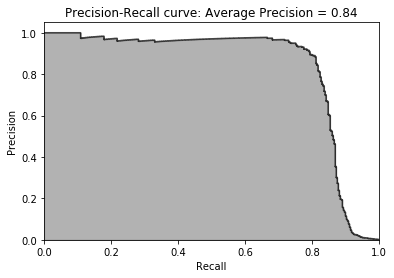

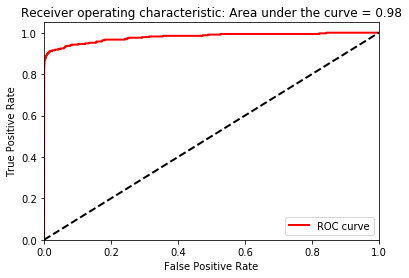

In [104]:
preds = pd.concat([y_train,predictionsBasedOnKFolds.loc[:,'prediction']], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsLightGBMGradientBoosting = preds.copy()

precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],preds['prediction'])
average_precision = average_precision_score(preds['trueLabel'],preds['prediction'])

# Precision-Recall curve of training set
plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))


# auROC curve of training set
fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()


The precision recall curve shows that the model can catch approximately 80% of all the fraud with approximately 80% precision. The average precision is 0.84.

The auROC curve is 0.98. 

#### Test Set Evaluation

In [105]:
predictionsTestSetLightGBMGradientBoosting = pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
predictionsTestSetLightGBMGradientBoosting.loc[:,'prediction'] = gbm.predict(X_test, num_iteration=gbm.best_iteration)
logLossTestSetLightGBMGradientBoosting = log_loss(y_test, predictionsTestSetLightGBMGradientBoosting)
print("Log Loss of LightGBM Gradient Boosting on Test Set: ", logLossTestSetLightGBMGradientBoosting)

Log Loss of LightGBM Gradient Boosting on Test Set:  0.0024722336304300262


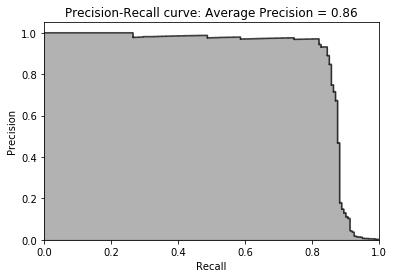

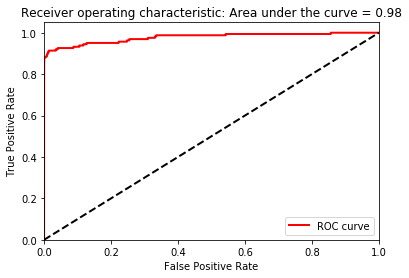

In [106]:
precision, recall, thresholds = precision_recall_curve(y_test,predictionsTestSetLightGBMGradientBoosting)
average_precision = average_precision_score(y_test,predictionsTestSetLightGBMGradientBoosting)

# Precision-Recall curve of test set
plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

# auROC curve of test set
fpr, tpr, thresholds = roc_curve(y_test,predictionsTestSetLightGBMGradientBoosting)
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

The results of LightGBM gradient boosting are impressive, catching over 90% of the fraudulent transactions with nearly 90% precision. This means that when catching 80% of the total fraud, the model gets only 10% of the cases wrong.

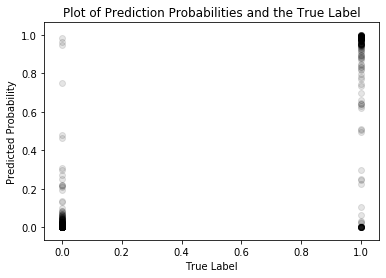

In [107]:
# Plot of prediction probabilities and the true label
scatterData = predictionsTestSetLightGBMGradientBoosting.join(y_test,how='left')
scatterData.columns = ['Predicted Probability','True Label']
ax = sns.regplot(x="True Label", y="Predicted Probability", color='k', 
                 fit_reg=False, scatter_kws={'alpha':0.1},
                 data=scatterData).set_title( \
                'Plot of Prediction Probabilities and the True Label')

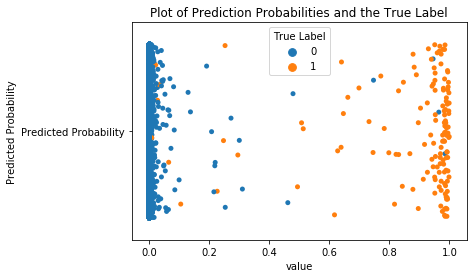

In [108]:
# Plot of prediction probabilities and the true label
scatterDataMelted = pd.melt(scatterData, "True Label", var_name="Predicted Probability")
ax = sns.stripplot(x="value", y="Predicted Probability", hue='True Label', jitter=0.4,
                   data=scatterDataMelted).set_title('Plot of Prediction Probabilities and the True Label')

The scatter data melted plot displays the predicted probabilities on the x axis. Based on this plot, the model does a resonably good job oof assigning a high probability of fraud to the transactions that are actually fraudulent. Sometimes the model is wrong and assigns a low probability to a case of actual fraud and high probability to a case of not fraud. Overall, the results are good.

# Unsupervised Model: Overcomplete Autoencoder with Linear Activation and Dropout

Autoencoders are a form of feature extraction which can be used to generate a new feature representation from the original set of features. Overcomplete autoencoders have more nodes in the hidden layer than either the input or output layer. Because the capacity of the nerual network model is so high, the autoencoder simply memorizes the observation it trains on. It will overfit the training data and will perform very poorly in separating fraudulent transactions from normal ones. To avoid this, two regulazionation techniques are used:
- Dropout. This will force the autoencoder to drop out some defined percentage of units from the layers in the neural network. With this new constraint, the overcomplete autoencoder will not simply memorize the credit card transactions in the trainins set. Instead, it will generalize more. The dropout percentage used is 5%, which is applied to the hidden layer.
- Sparsity. This will make it harder for the autoencoder to memorize the identity funciton.

In [200]:
# Import TensorFlow and Keras
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy

In [201]:
# Load the data
data1 = pd.read_csv('creditcard.csv')

In [202]:
# Drop class and time features
dataX1 = data1.copy().drop(['Class','Time'],axis=1)
dataY1 = data1['Class'].copy()

In [204]:
# Scale data
featuresToScale1 = dataX1.columns
standardizeX1 = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
dataX1.loc[:,featuresToScale1] = standardizeX1.fit_transform(dataX1[featuresToScale1])

In [205]:
# Split into train and test
X_train1, X_test1, y_train1, y_test1 = train_test_split(dataX1, dataY1, test_size=0.33, random_state=2022, stratify=dataY1)

X_train_AE = X_train1.copy()
X_test_AE = X_test1.copy()

#### Function to calculate the reconstraction error between the original feature and the new feature matrix
Dimensionality reduction algorithms reduce the dimensionality of data while attempting to minimize the reconstruction error. The goal is to capture the most important information of the original feature to reconstruct the original feature set from the reduced feature set as well as possible.

For this credit cart transactions dataset, the algorithms will have the largest reconstruction error on those transactions that are hardest to model (those that occur the least often and are the most anomalous). Since fraud is rare and different from normal transactions, the fraudulent transactions should have the largest reconstruction error.

The reconstruction error for each transaction is the sum of the squared differences between the original feature matrix and the reconstructed matrix using the dimensionality reduction algorithm. Then, the su of the squared differences is scaled using the min-max range od the sum of the squared differences for the entire dataset so that all the reconstruction errors are within a zero to one range.

The transactions that have the largest sum of squared differences will have an error close to one (most anomalous and most likely to be fraudulent), while those that have the smallest sum od squared differences will have an error close to zero (most likely to be normal transactions).

Here are the function that calculates the reconstruction error:

In [207]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - \
                   np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [208]:
# Function to plot Precion-Recall curve and auROC curve
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = precision_recall_curve(preds['trueLabel'], preds['anomalyScore'])
    average_precision = average_precision_score(preds['trueLabel'], preds['anomalyScore'])
    
    # Plot Precision-Recall curve
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

    # Plot auROC curve
    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision

In [217]:
# Call neural network API
model = Sequential()

# Generate hidden layer with 40 nodes using linear activation
model.add(Dense(units=40, activation='linear', activity_regularizer=regularizers.l1(10e-5),
                input_dim=29,name='hidden_layer'))
# Add dropout layer with rate 0.05
model.add(Dropout(0.05))

# Generate output layer with 29 nodes
model.add(Dense(units=29, activation='linear'))

In [218]:
# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [219]:
# Train the model
history = model.fit(x=X_train_AE, y=X_train_AE,
                    epochs=10,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(X_train_AE, X_train_AE),
                    verbose=1)

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 11s 59us/step - loss: 0.1654 - accuracy: 0.8072 - val_loss: 0.0480 - val_accuracy: 0.9770
Epoch 2/10
190820/190820 [==============================] - 13s 66us/step - loss: 0.0792 - accuracy: 0.8626 - val_loss: 0.0369 - val_accuracy: 0.9753
Epoch 3/10
190820/190820 [==============================] - 12s 62us/step - loss: 0.0702 - accuracy: 0.8621 - val_loss: 0.0305 - val_accuracy: 0.9778
Epoch 4/10
190820/190820 [==============================] - 13s 66us/step - loss: 0.0650 - accuracy: 0.8596 - val_loss: 0.0262 - val_accuracy: 0.9781
Epoch 5/10
190820/190820 [==============================] - 14s 72us/step - loss: 0.0629 - accuracy: 0.8587 - val_loss: 0.0236 - val_accuracy: 0.9792
Epoch 6/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.0615 - accuracy: 0.8595 - val_loss: 0.0269 - val_accuracy: 0.9664
Epoch 7/10
190820/190820 [======================

93987/93987 [==============================] - 1s 15us/step


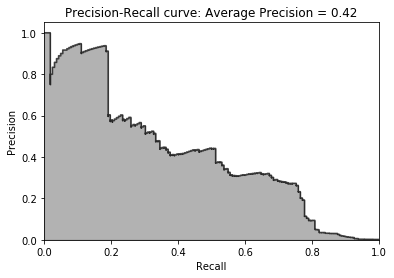

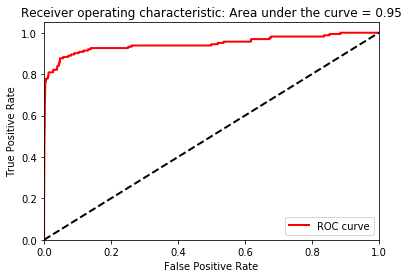

In [220]:
# Evaluate on test set
predictions = model.predict(X_test1, verbose=1)
anomalyScoresAE = anomalyScores(X_test1, predictions)
preds = plotResults(y_test1, anomalyScoresAE, True)
model.reset_states()

The average precision is 0.42, which is not very good when compared to the supervised model, which had an average precision of 0.86. The overcomplete autoencoder has very poor performance in detecting the fraudulent credit card transactions.

# Semisupervised Model
The plan is to take the representation learned by the autoencoder in the hidden layer, combine it with the original training set and feed this into the supervised model.

In [221]:
# Load the data
data2 = pd.read_csv('creditcard.csv')

dataX2 = data2.copy().drop(['Class','Time'],axis=1)
dataY2 = data2['Class'].copy()

# Scale data
featuresToScale2 = dataX2.columns
standardizeX2 = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
dataX2.loc[:,featuresToScale2] = standardizeX2.fit_transform(dataX[featuresToScale2])

# Split into train and test
X_train2, X_test2, y_train2, y_test2 = train_test_split(dataX2, dataY2, test_size=0.33, random_state=2021, stratify=dataY2)

As real-world problems involving payment fraud have similarly low incidences of fraud (1 fraud per 10000 cases), 90% of the fraudulent credit card transactions are dropped from the training set to simulate this  real world scenario.

In [223]:
# Drop 95% of the labels from the training set
toDrop = y_train2[y_train2==1].sample(frac=0.90,random_state=2021)
X_train2.drop(labels=toDrop.index,inplace=True)
y_train2.drop(labels=toDrop.index,inplace=True)

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [225]:
# Function used to calculate the reconstruction error
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - \
                   np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [226]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = precision_recall_curve(preds['trueLabel'], preds['anomalyScore'])
    average_precision = average_precision_score(preds['trueLabel'], preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision

#### New function to assess precision
The following function will help to asses the precision of the model at a certain level of recall. The goal is to determine what hte model's precision is to catch 75% of the fraudulent credit card transactions in the test set. The higher the precision, the better the model.


In [227]:
def precisionAnalysis(df, column, threshold):
    df.sort_values(by=column, ascending=False, inplace=True)
    threshold_value = threshold*df.trueLabel.sum()
    i = 0
    j = 0
    while i < threshold_value+1:
        if df.iloc[j]["trueLabel"]==1:
            i += 1
        j += 1
    return df, i/j

In [229]:
k_fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2021)


### Supervised model: Light Gradient Boosting Machine

In [230]:
params_lightGB2 = {
    'task': 'train',
    'application':'binary',
    'num_class':1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2021,
    'verbose': 0,
    'num_threads':16
}

In [231]:
# Train the LightGBM algorithm
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[], index=y_train2.index, columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train2)), y_train2.ravel()):
    X_train_fold, X_cv_fold = X_train2.iloc[train_index,:], X_train2.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train2.iloc[train_index], y_train2.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB2, lgb_train, num_boost_round=2000, valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, gbm.predict(X_train_fold, num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLightGBMGradientBoosting = log_loss(y_train, predictionsBasedOnKFolds.loc[:,'prediction'])
print('LightGBM Gradient Boosting Log Loss: ', loglossLightGBMGradientBoosting)

[1]	valid_0's binary_logloss: 0.0020382
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.00184524
[3]	valid_0's binary_logloss: 0.00145219
[4]	valid_0's binary_logloss: 0.00192681
[5]	valid_0's binary_logloss: 0.00191255
[6]	valid_0's binary_logloss: 0.00190154
[7]	valid_0's binary_logloss: 0.00188847
[8]	valid_0's binary_logloss: 0.00188098
[9]	valid_0's binary_logloss: 0.00187277
[10]	valid_0's binary_logloss: 0.00186739
[11]	valid_0's binary_logloss: 0.00185616
[12]	valid_0's binary_logloss: 0.00185074
[13]	valid_0's binary_logloss: 0.00184668
[14]	valid_0's binary_logloss: 0.00184239
[15]	valid_0's binary_logloss: 0.00183867
[16]	valid_0's binary_logloss: 0.00183545
[17]	valid_0's binary_logloss: 0.00183174
[18]	valid_0's binary_logloss: 0.00182806
[19]	valid_0's binary_logloss: 0.00182452
[20]	valid_0's binary_logloss: 0.00182126
[21]	valid_0's binary_logloss: 0.00181808
[22]	valid_0's binary_logloss: 0.00181104
[23]	valid_0's binary_lo

ValueError: Found input variables with inconsistent numbers of samples: [190523, 190820]

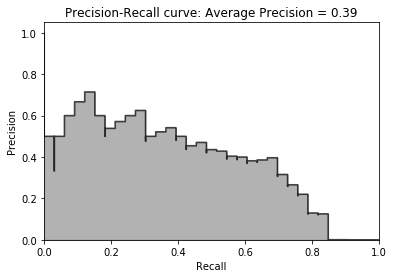

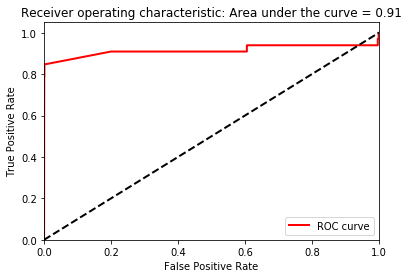

In [232]:
# Precision-recall curve and auROC of the training set
preds, average_precision = plotResults(y_train2, predictionsBasedOnKFolds.loc[:,'prediction'], True)

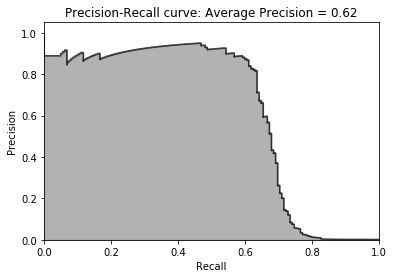

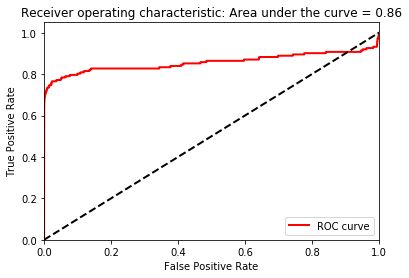

In [233]:
# Precision-recall curve and auROC of the test set
predictions = pd.Series(data=gbm.predict(X_test2, num_iteration=gbm.best_iteration), index=X_test2.index)
preds, average_precision = plotResults(y_test2, predictions, True)

In [234]:
# Precision when catching 75% of the fraud 
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print("Precision at 75% recall", precision)

Precision at 75% recall 0.056292906178489706


The average precision on the test based on the precision-recall curve is 0.62. This means that when catching 75% of the fraud, the model has a precision of just 5.6%.

### Unsupervised Model: Overcomplete Autoencoder with Linear Activation and Dropout
The overcomplete autoencoder with a linear activation function will have 40 nodes in the hidden layer and a dropout of 2%. However, the training set will be adjusted by oversampling the number of fraudulent cases, adding more fraudulent cases to the dataset. Having dropped 90% of the fraudulent cases from the training set (which has 67% of 492 fraudulent cases), there are only 33 fraudulent cases left. These 33 fraudulent cases will be duplicated 100 times and then appended to the training set. This is done only with the training set, there is no oversampling with the test set.

In [235]:
# Oversampling the number of fraudulent cases in the training set
oversample_multiplier = 100

X_train_original = X_train2.copy()
y_train_original = y_train2.copy()
X_test_original = X_test2.copy()
y_test_original = y_test2.copy()

X_train_oversampled = X_train2.copy()
y_train_oversampled = y_train2.copy()
X_train_oversampled = X_train_oversampled.append([X_train_oversampled[y_train2==1]]*oversample_multiplier,
                                                 ignore_index=False)
y_train_oversampled = y_train_oversampled.append([y_train_oversampled[y_train2==1]]*oversample_multiplier,
                                                 ignore_index=False)

X_train2 = X_train_oversampled.copy()
y_train2 = y_train_oversampled.copy()

In [238]:
# Call neural network API
model = Sequential()

# Generate hidden layer with 40 nodes using linear activation
model.add(Dense(units=40, activation='linear', activity_regularizer=regularizers.l1(10e-5),
                input_dim=29,name='hidden_layer'))
# Add a dropout layer with rate 0.5
model.add(Dropout(0.05))

# Generate output layer with 29 nodes
model.add(Dense(units=29, activation='linear'))

In [239]:
# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [240]:
# Train the model
history = model.fit(x=X_train2, y=X_train2,
                    epochs=5,
                    batch_size=32,
                    shuffle=True,
                    validation_split=0.20,
                    verbose=1)

Train on 155058 samples, validate on 38765 samples
Epoch 1/5
155058/155058 [==============================] - 6s 40us/step - loss: 0.1739 - accuracy: 0.7988 - val_loss: 0.1399 - val_accuracy: 0.9622
Epoch 2/5
155058/155058 [==============================] - 8s 53us/step - loss: 0.0752 - accuracy: 0.8644 - val_loss: 0.0866 - val_accuracy: 0.9496
Epoch 3/5
155058/155058 [==============================] - 10s 62us/step - loss: 0.0665 - accuracy: 0.8641 - val_loss: 0.1707 - val_accuracy: 0.9270
Epoch 4/5
155058/155058 [==============================] - 8s 51us/step - loss: 0.0625 - accuracy: 0.8627 - val_loss: 0.1221 - val_accuracy: 0.9547
Epoch 5/5
155058/155058 [==============================] - 8s 52us/step - loss: 0.0592 - accuracy: 0.8625 - val_loss: 0.0614 - val_accuracy: 0.9745


190523/190523 [==============================] - 2s 13us/step


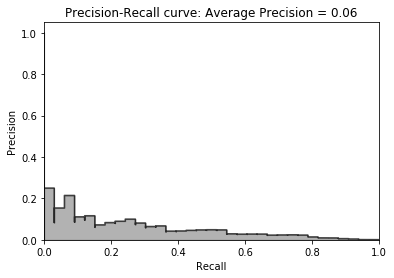

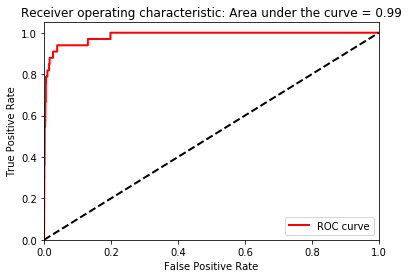

In [241]:
# Precision-recall curve and auROC of the training set
predictionsTrain = model.predict(X_train_original, verbose=1)
anomalyScoresAETrain = anomalyScores(X_train_original, predictionsTrain)
preds, average_precision = plotResults(y_train_original, anomalyScoresAETrain, True)

93987/93987 [==============================] - 1s 15us/step


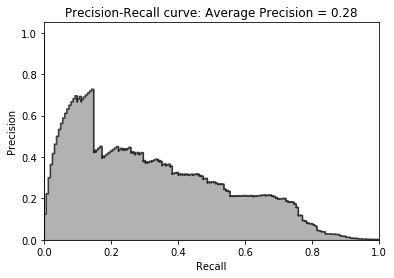

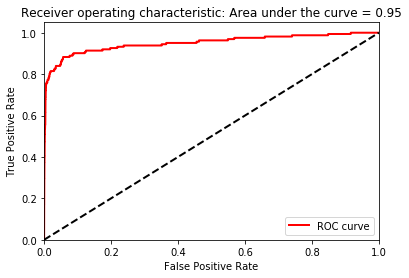

In [242]:
# Precision-recall curve and auROC of the test set
predictions = model.predict(X_test2, verbose=1)
anomalyScoresAE = anomalyScores(X_test2, predictions)
preds, average_precision = plotResults(y_test2, anomalyScoresAE, True)

In [243]:
# precision when catching 75% of the fraud
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print("Precision at 75% recall", precision)

Precision at 75% recall 0.15708812260536398


The average precision on the test based on the precision-recall curve is 0.28. This means that when catching 75% of the fraud, the model has a precision of just 15.7%. While the average precision of the unsupervised model is worse than the average precision of the supervised one (0.62), the precision of 15.7% at 75% recall is better. However, the unsupervised solution by itself is still not great.

### Semi-supervised Model
The strategy is to take the representation learned by the autoencoder in the hidden layer, combine it with the original training set and feed this into the gradient boosting algorithm.

In [245]:
# Get the hidden layer output
layer_name = 'hidden_layer'

intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
intermediate_output_train = intermediate_layer_model.predict(X_train_original)
intermediate_output_test = intermediate_layer_model.predict(X_test_original)

In [246]:
# Store the autoencoder's representations into DataFrames
intermediate_output_trainDF = pd.DataFrame(data=intermediate_output_train, index=X_train_original.index)
intermediate_output_testDF = pd.DataFrame(data=intermediate_output_test, index=X_test_original.index)

In [247]:
# Combine the DataFrames with the original dataset
X_train2 = X_train_original.merge(intermediate_output_trainDF, left_index=True,right_index=True)
X_test2 = X_test_original.merge(intermediate_output_testDF, left_index=True,right_index=True)
y_train2 = y_train_original.copy()

In [248]:
# Training the gradient boosting algorithm on the new trainin set of 69 features
# (29 from the original dataset and 40 from the autoencoder's represetation)

trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train2.index, columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train2)), y_train2.ravel()):
    X_train_fold, X_cv_fold = X_train2.iloc[train_index,:], X_train2.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train2.iloc[train_index], y_train2.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB2, lgb_train, num_boost_round=5000, valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, gbm.predict(X_train_fold, num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLightGBMGradientBoosting = log_loss(y_train2, predictionsBasedOnKFolds.loc[:,'prediction'])
print('LightGBM Gradient Boosting Log Loss: ', loglossLightGBMGradientBoosting)

[1]	valid_0's binary_logloss: 0.00204372
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.00137834
[3]	valid_0's binary_logloss: 0.00133687
[4]	valid_0's binary_logloss: 0.00130462
[5]	valid_0's binary_logloss: 0.00127867
[6]	valid_0's binary_logloss: 0.00125484
[7]	valid_0's binary_logloss: 0.0012356
[8]	valid_0's binary_logloss: 0.00121911
[9]	valid_0's binary_logloss: 0.0012037
[10]	valid_0's binary_logloss: 0.00119052
[11]	valid_0's binary_logloss: 0.00117927
[12]	valid_0's binary_logloss: 0.00116863
[13]	valid_0's binary_logloss: 0.00115806
[14]	valid_0's binary_logloss: 0.00114882
[15]	valid_0's binary_logloss: 0.00113839
[16]	valid_0's binary_logloss: 0.00112867
[17]	valid_0's binary_logloss: 0.00111935
[18]	valid_0's binary_logloss: 0.00111019
[19]	valid_0's binary_logloss: 0.00110002
[20]	valid_0's binary_logloss: 0.00109336
[21]	valid_0's binary_logloss: 0.00108716
[22]	valid_0's binary_logloss: 0.0010797
[23]	valid_0's binary_logl

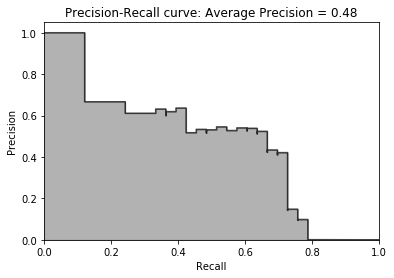

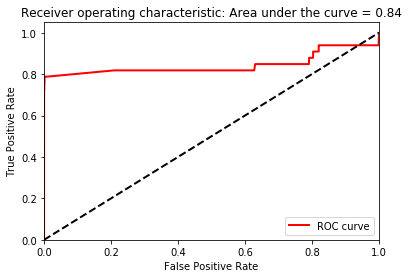

In [249]:
# Precision-recall curve and auROC curve of the training set
preds, average_precision = plotResults(y_train2, predictionsBasedOnKFolds.loc[:,'prediction'], True)

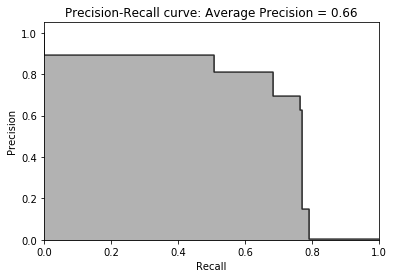

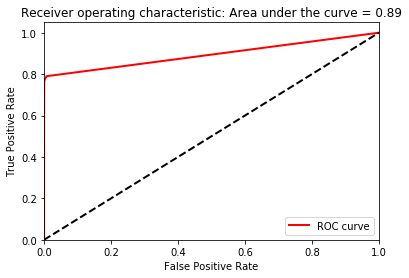

In [250]:
# Precision-recall curve and auROC of the test set
predictions = pd.Series(data=gbm.predict(X_test2, num_iteration=gbm.best_iteration), index=X_test2.index)
preds, average_precision = plotResults(y_test2, predictions, True)

In [251]:
# Precision in catchin 75% of fraud
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print(precision)

0.7321428571428571


The average precision on the test based on the precion-recall curve is 0.66. This is higher than both the supervised and the unsupervised models. When catching 75% of the fraud, the semi-supervised model has a precision of 73%. This is a considerable improvement.

In [261]:
# Show the feature importance values from the model
featuresImportance = pd.DataFrame(data=list(gbm.feature_importance()), index=X_train2.columns,columns=['featureImportance'])
featuresImportance = featuresImportance/featuresImportance.sum()
featuresImportance.sort_values(by='featureImportance', ascending=False,inplace=True)
featuresImportance.head(5)

,featureImportance
V1,0.272727
V10,0.090909
22,0.090909
V19,0.090909
V16,0.090909


# Conclusion
Both supervised model and unsupervised model have important roles. In fact, one of the top features is a feature learned by the autoencoder (non V feature) while others are the principal component from the original dataset. The semi-supervised model performs better that the supervised and unsupervused models when 90% of the fraudulent transactions are dropped from the training set.